In [1]:
#!pip install -q pyyaml h5py  # Required to save models in HDF5 format
from matplotlib import cm
from matplotlib import colorbar
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import pearsonr

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.utils import check_array

np.random.seed(1634)
tf.random.set_seed(264)

## Plot function

In [2]:
def plotLogs(filename, welllog,dt_predicted = None):
    fig,axes = plt.subplots(1,6,sharey=True,figsize=(12,10))
    plt.suptitle(filename)
    plt.gca().invert_yaxis()
    
    ax = axes[0]
    ax.set_ylim([max(welllog['DEPT']),min(welllog['DEPT'])])
    ax.grid(which='both')
    ax.plot(welllog['GR']    , welllog['DEPT']    , label='Input',  color='cyan',linewidth=1.2, linestyle='-')
    ax.set_xlabel('GR (API)')
    ax.set_ylabel('DEPTH (m)')
    ax.legend(loc='upper right')
    
    ax = axes[1]
    ax.grid(which='both')
    ax.plot(welllog['RHOB']    , welllog['DEPT']    , label='Input',  color='red',linewidth=1.2, linestyle='-')
    ax.set_xlabel('RHOB (g/cc)')
    ax.set_ylabel('DEPTH (m)')
    ax.legend(loc='upper right')
    
    ax = axes[2]
    ax.grid(which='both')
    ax.plot(welllog['NPHI']    , welllog['DEPT']    , label='Input',  color='yellow',linewidth=1.2, linestyle='-')
    ax.set_xlabel('NPHI (pu)')
    ax.set_ylabel('DEPTH (m)')
    ax.legend(loc='upper right')

    ax = axes[3]
    ax.grid(which='both')
    ax.plot(welllog['CALI']    , welllog['DEPT']    , label='Input',  color='black',linewidth=1.2, linestyle='-')
    ax.set_xlabel('CALI (in)')
    ax.set_ylabel('DEPTH (m)')
    ax.legend(loc='upper right')

    ax = axes[4]
    ax.grid(which='both')
    ax.set_xscale('log')
    ax.plot(welllog['RESI']    , welllog['DEPT']    , label='Input',  color='orange',linewidth=1.2, linestyle='-')
    ax.set_xlabel('RESI (ohm.m)')
    ax.set_ylabel('DEPTH (m)')
    ax.legend(loc='upper right')

    ax = axes[5]
    ax.grid(which='both')
    ax.plot(welllog['DT']    , welllog['DEPT']    , label='Input',  color='magenta',linewidth=1.2, linestyle='-')
    if isinstance(dt_predicted, pd.DataFrame):
        ax.plot(dt_predicted['DT']    , welllog['DEPT'] , label='Predicted', color='green',linewidth=0.8, linestyle='--')
    ax.set_xlabel('DT ($\mu$s/ft)')
    ax.set_ylabel('DEPTH (m)')
    ax.legend(loc='upper right')

    plt.show()

## Load data

In [3]:
CSVFILE = 'welllogs.csv'
welllogs_df = pd.read_csv(CSVFILE)

# welllogs_df['RESI'] = welllogs_df['RESI'].map(np.log10)
filenames = pd.unique(welllogs_df['filename'])
filenames

array(['BREAKER-1.ASC', 'LEE_1_008.ASC', 'LEE_2_006.ASC',
       'BOYD_1_LWD_180_674.ASC', 'JOSEPHIINE_1_LWD_690_2675.ASC',
       'TEEWINOT_1_LWD_472_2252.ASC', 'NORTH_HARRIET_1_004.ASC',
       'NORTH_GIPSY_1_003.LAS', 'MISTINGUETT_1_LWD_649_2352.LAS',
       'MONTY_1_LWD_61_2492.LAS', 'CHERVIL_1_WL_39_2661.LAS',
       'NORTH_HERALD_1_WL_47_2608.LAS'], dtype=object)

In [4]:
welllogs_df.head()
#frame

,Unnamed: 0,DEPT,CALI,DT,GR,NPHI,RESI,RHOB,filename
0,0,710.1,9.077,158.0,108.654,61.64,0.590,2.13,BREAKER-1.ASC
1,1,710.7,9.782,152.9,99.889,50.45,0.988,2.15,BREAKER-1.ASC
2,2,711.5,8.687,152.4,116.795,62.38,0.714,2.14,BREAKER-1.ASC
3,3,711.6,8.687,155.6,114.532,63.24,0.751,2.14,BREAKER-1.ASC
4,4,712.2,8.651,157.5,122.552,61.74,0.606,2.12,BREAKER-1.ASC


In [5]:
 welllogs_df.describe()

,Unnamed: 0,DEPT,CALI,DT,GR,NPHI,RESI,RHOB
count,124960.000000,124960.000000,124960.000000,124960.000000,124960.000000,124960.000000,124960.000000,124960.000000
mean,62479.500000,1816.570587,9.649057,89.538167,126.127641,34.141154,4.027979,2.453285
std,36072.989156,477.168198,1.884676,15.204283,38.553550,13.217229,13.434364,0.123275
min,0.000000,473.200000,7.485352,54.289060,16.343750,1.196289,0.300000,2.010000
25%,31239.750000,1474.200000,8.560400,79.100000,104.953100,22.400000,1.630000,2.375000
50%,62479.500000,1815.600000,8.610000,86.900000,136.780000,35.449110,2.630000,2.461000
75%,93719.250000,2176.800000,10.349610,96.890000,154.674500,43.980000,4.196503,2.541000
max,124959.000000,2944.900000,21.722660,158.400000,453.654000,87.410000,2000.000000,2.800000


## Gardner relationship fitting data from all the wells

570.8622481095668 -2.0819097333683785


,Unnamed: 0,DEPT,CALI,DT,GR,NPHI,RESI,RHOB,filename,GARDNER_DT
0,0,710.1,9.077,158.0,108.654,61.64,0.590,2.13,BREAKER-1.ASC,118.270009
1,1,710.7,9.782,152.9,99.889,50.45,0.988,2.15,BREAKER-1.ASC,115.991044
2,2,711.5,8.687,152.4,116.795,62.38,0.714,2.14,BREAKER-1.ASC,117.122322
3,3,711.6,8.687,155.6,114.532,63.24,0.751,2.14,BREAKER-1.ASC,117.122322
4,4,712.2,8.651,157.5,122.552,61.74,0.606,2.12,BREAKER-1.ASC,119.434424


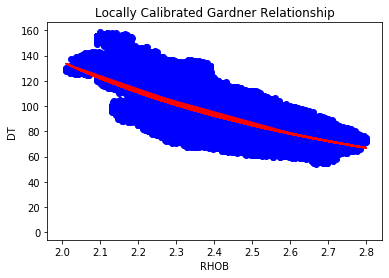

In [6]:
def powerlaw(x,amp,index):
    return amp * (x**index)

def Gardner_coeff(welllogs_df):
    xdata = welllogs_df['RHOB']
    ydata = welllogs_df['DT']
    logx = np.log10(welllogs_df['RHOB'])
    logy = np.log10(welllogs_df['DT'])
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y: (y - fitfunc(p, x))
    
    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,args=(logx,logy), full_output=1)
    pfinal = out[0]
    index = pfinal[1]
    amp = 10.0**pfinal[0]

    return (amp,index)

def plot_Gardner(xdata,ydata,ygardner):           
    plt.clf()
    plt.plot(2, 2)
    plt.scatter(xdata, ydata,color='blue')     
    plt.plot(xdata,ygardner ,color='red')     
    plt.title('Locally Calibrated Gardner Relationship')
    plt.xlabel('RHOB')
    plt.ylabel('DT')
    
amp,index = Gardner_coeff(welllogs_df)
print(amp,index)
welllogs_df['GARDNER_DT'] = powerlaw(welllogs_df['RHOB'],amp,index)
plot_Gardner(welllogs_df['RHOB'],welllogs_df['DT'],welllogs_df['GARDNER_DT'])

welllogs_df.head()

## From the 12 avaliable wells, I have selected two to be the test dataset

In [7]:
# train_filename = filenames[4]
# train_welllog  = welllogs_df[welllogs_df['filename'] == train_filename]

## 8 wells used for train, 2 (CHERVIL_1_WL_39_2661.LAS and NORTH_HERALD_1_WL_47_2608.LAS) and 2 for test.
#test_filenames  = ['JOSEPHIINE_1_LWD_690_2675.ASC','CHERVIL_1_WL_39_2661.LAS','MONTY_1_LWD_61_2492.LAS','NORTH_HERALD_1_WL_47_2608.LAS',]

## After train with 8 wells and get the best hyperparamenters, lets re-fit the model using 10 wells. 
test_filenames  = ['JOSEPHIINE_1_LWD_690_2675.ASC','MONTY_1_LWD_61_2492.LAS']

train_welllog = welllogs_df.copy()
for i,filename in enumerate(test_filenames):
    train_welllog  = train_welllog[train_welllog['filename'] != filename]
    if i == 0:
        test_welllog = welllogs_df[welllogs_df['filename'] == filename]
    else:
        test_welllog = pd.concat([test_welllog,welllogs_df[welllogs_df['filename'] == filename]])

train_filenames = pd.unique(train_welllog['filename'])
# for i,filename in enumerate(train_filenames):
#     plotLogs(filename + " (TRAINING WELL)",train_welllog[train_welllog['filename'] == filename])
# for i,filename in enumerate(test_filenames):
#     plotLogs(filename + " (TESTING WELL)",test_welllog[test_welllog['filename'] == filename])

## Select the features and the target

In [8]:
# features_columns = ['GR','RHOB','NPHI','CALI','RESI']
# features_columns = ['DEPT','GR','RHOB','NPHI','RESI']
features_columns = ['GR','RHOB','NPHI','RESI']
target_column   = 'DT'
n_features = len(features_columns)

X_train = train_welllog[['filename'] + features_columns]
y_train = train_welllog[target_column]

X_test  = test_welllog[['filename'] + features_columns]
y_test  = test_welllog[target_column]

## Calculate Pearson's correlation between features and target

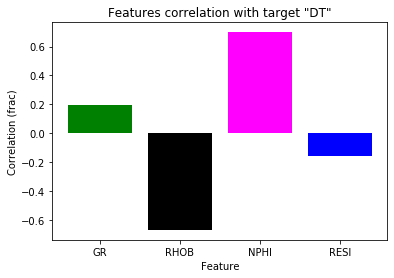

In [9]:
corr = np.zeros(len(features_columns))
for i in range(len(features_columns)):
    corr[i],_ = pearsonr(welllogs_df[features_columns[i]],welllogs_df['DT'])
#print(np.around(corr,decimals=2))

def plot_corr(features, target,corr):
    colors=['green','black','magenta','blue','orange']
    plt.bar(features,corr,color=colors)
    plt.title('Features correlation with target "%s"'%(target))
    plt.xlabel('Feature')
    plt.ylabel('Correlation (frac)')
    plt.show()

plot_corr(features_columns, target_column,corr)

## Normalize logs

In [10]:
#NORMALIZE LOGS
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaler.fit(X_train[features_columns])
y_scaler.fit(y_train.values.reshape(-1, 1))

X_train_norm = X_scaler.transform(X_train[features_columns].values)
y_train_norm = y_scaler.transform(y_train.values.reshape(-1, 1))

X_test_norm = X_scaler.transform(X_test[features_columns].values)
y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

#DENORMALIZE LOGS
X_test_denorm = X_scaler.inverse_transform(X_test_norm)
y_test_denorm = y_scaler.inverse_transform(y_test_norm)

#create panda DF from normalized and denormalized logs 
log_test_norm   = pd.DataFrame(data=np.concatenate((X_test_norm, y_test_norm), axis=1), columns=features_columns+[target_column])
log_test_norm   = pd.concat([X_test['filename'].reset_index(),log_test_norm],axis=1)

log_test_denorm = pd.DataFrame(data=np.concatenate((X_test_denorm, y_test_denorm), axis=1), columns=features_columns+[target_column])
log_test_denorm = pd.concat([X_test['filename'].reset_index(),log_test_denorm],axis=1)

# for i,filename in enumerate(test_filenames):
#     plotLogs(filename + " (TESTING WELL - NORMALIZED)"  ,log_test_norm[log_test_norm['filename'] == filename])
#     plotLogs(filename + " (TESTING WELL - DENORMALIZED)",log_test_denorm[log_test_denorm['filename'] == filename])


## PCA

In [11]:
with_PCA = False
n_components = 4
if with_PCA:
    pca_tf = PCA(n_components=n_components)
    pca_tf.fit(X_train_norm)
    pca_tf.explained_variance_ratio_
    n_inputs = n_components
else:
    n_inputs = n_features

## FFNN - Create the layers and compile

In [12]:
def create_model():
    keras.backend.set_epsilon(1)
#     layers = [
#         keras.layers.Dense(n_inputs, activation='relu', input_shape=(n_inputs,), name='Input_layer'),
#        keras.layers.Dense(10*n_inputs, activation='relu', name='Layer1'),
#        #keras.layers.Dropout(0.1),
#        keras.layers.Dense(10*n_inputs, activation='relu', name='Layer2'),
#        keras.layers.Dense(10*n_inputs, activation='relu', name='Layer3'),
#        keras.layers.Dropout(0.1),
#        keras.layers.Dense(10*n_inputs, activation='relu', name='Layer4'),
#        keras.layers.Dense(10*n_inputs, activation='relu', name='Layer5'),
#        keras.layers.Dense(10*n_inputs, activation='relu', name='Layer6'),
#        keras.layers.Dense(1, name='Output_layer')
#     ]
    
    layers = [
        keras.layers.Dense(n_inputs, activation='relu', input_shape=(n_inputs,), name='Input_layer'),
        keras.layers.Dense(30, activation='relu', name='Layer1'),
        #keras.layers.Dropout(0.1),
        keras.layers.Dense(30, activation='relu', name='Layer2'),
        keras.layers.Dense(30, activation='relu', name='Layer3'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(30, activation='relu', name='Layer4'),
        keras.layers.Dense(30, activation='relu', name='Layer5'),
        #keras.layers.Dense(10, activation='relu', name='Layer6'),
        #keras.layers.Dense(15, activation='relu', name='Layer7'),
        keras.layers.Dense(1, activation='relu', name='Output_layer')
    ]
    
    model = keras.models.Sequential(layers)
    model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])
    return model

## GridSearchCV - Search for the best parameters

In [13]:
# # define the grid search parameters
# batch_size = [10, 20, 40, 100]
# epochs = [5, 10, 20]

# #create dictionary
# param_grid = dict(batch_size=batch_size, epochs=epochs)

# #Prepare model to GridSearchCV
# modelCV = KerasClassifier(build_fn=create_model, verbose=1)

# grid = GridSearchCV(estimator=modelCV, param_grid=param_grid, cv=3, n_jobs=1, scoring=make_scorer(mean_squared_error), verbose=1)

# if with_PCA:
#     grid_result = grid.fit( pca_tf.transform(X_train_norm), y_train_norm)
# else:
#     grid_result = grid.fit(X_train_norm, y_train_norm)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [14]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          (None, 4)                 20        
_________________________________________________________________
Layer1 (Dense)               (None, 30)                150       
_________________________________________________________________
Layer2 (Dense)               (None, 30)                930       
_________________________________________________________________
Layer3 (Dense)               (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
Layer4 (Dense)               (None, 30)                930       
_________________________________________________________________
Layer5 (Dense)               (None, 30)                9

## FFNN - Fit

In [15]:
%%time
if with_PCA:
    model.fit( pca_tf.transform(X_train_norm), y_train_norm, epochs=10,batch_size=100)
else:
    model.fit(X_train_norm, y_train_norm, epochs=15)


Train on 99742 samples
Epoch 1/15
99742/99742 [==============================] - 9s 94us/sample - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_percentage_error: 9.7486
Epoch 2/15
99742/99742 [==============================] - 8s 82us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_percentage_error: 6.1180
Epoch 3/15
99742/99742 [==============================] - 7s 71us/sample - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_percentage_error: 5.6267
Epoch 4/15
99742/99742 [==============================] - 6s 63us/sample - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_percentage_error: 5.4006
Epoch 5/15
99742/99742 [==============================] - 6s 63us/sample - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_percentage_error: 5.2882
Epoch 6/15
99742/99742 [==============================] - 6s 62us/sample - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_percentage_error: 5.1944
Epoch 7/15
99742/99742 [=====

## FFNN - Evaluate the ERROR

In [16]:
for i,filename in enumerate(test_filenames):
    current_log = log_test_norm[log_test_norm['filename'] == filename]

    if with_PCA:
        print('mean_absolute_percentage_error for well "%s" is %.2f%%' %(filename,model.evaluate(pca_tf.transform(current_log[features_columns].values), current_log[target_column].values,verbose=0)[2]))
    else:
        print('mean_absolute_percentage_error for well "%s" is %.2f%%' %(filename,model.evaluate(current_log[features_columns].values, current_log[target_column].values,verbose=0)[2]))


mean_absolute_percentage_error for well "JOSEPHIINE_1_LWD_690_2675.ASC" is 4.26%
mean_absolute_percentage_error for well "MONTY_1_LWD_61_2492.LAS" is 3.11%


## FFNN - Save the model to disk

In [17]:
from joblib import dump, load
dump(X_scaler, 'ffnn_model.X_scaler') 
dump(y_scaler, 'ffnn_model.y_scaler') 
model.save('ffnn_model.h5')

## FFNN - Load the model to disk


In [18]:
new_model = tf.keras.models.load_model('ffnn_model.h5')
y_scaler = load('ffnn_model.y_scaler')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          (None, 4)                 20        
_________________________________________________________________
Layer1 (Dense)               (None, 30)                150       
_________________________________________________________________
Layer2 (Dense)               (None, 30)                930       
_________________________________________________________________
Layer3 (Dense)               (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
Layer4 (Dense)               (None, 30)                930       
_________________________________________________________________
Layer5 (Dense)               (None, 30)                9

## FFNN - Predict

mean_absolute_percentage_error for well "JOSEPHIINE_1_LWD_690_2675.ASC" is 4.26%


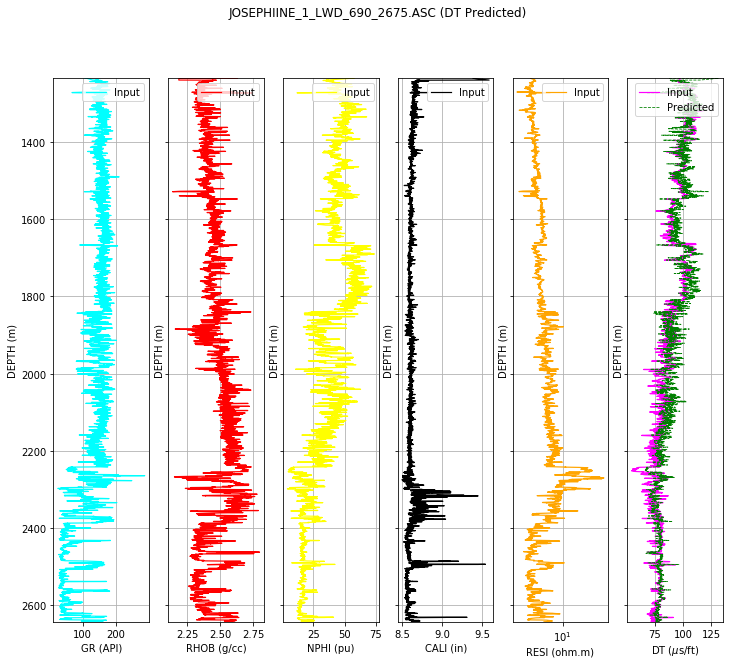

mean_absolute_percentage_error for well "MONTY_1_LWD_61_2492.LAS" is 3.11%


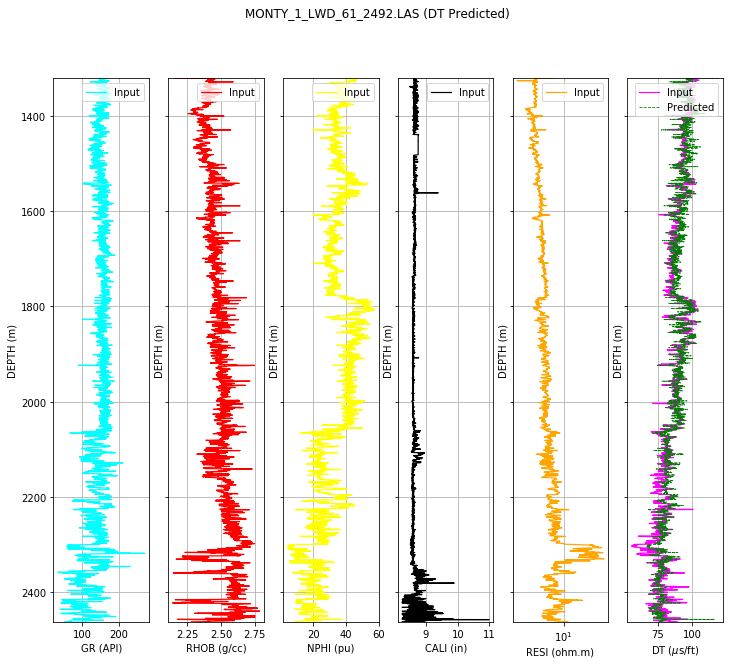

CPU times: user 3.13 s, sys: 264 ms, total: 3.4 s
Wall time: 2.76 s


In [19]:
%%time
for i,filename in enumerate(test_filenames):
    current_log_norm = log_test_norm[log_test_norm['filename'] == filename]
    current_log_denorm = log_test_denorm[log_test_denorm['filename'] == filename]

    if with_PCA:
        y_predict_norm = new_model.predict(pca_tf.transform(current_log_norm[features_columns].values))
    else:
        y_predict_norm = new_model.predict(current_log_norm[features_columns].values)

    y_predict = y_scaler.inverse_transform(y_predict_norm)
        
    log_predicted      = pd.DataFrame(data=y_predict, columns=[target_column])
    log_predicted_norm = pd.DataFrame(data=y_predict_norm, columns=[target_column])


    y_test_denorm = y_scaler.inverse_transform(current_log_norm['DT'].values.reshape(1,-1))
    
#     log_predicted = pd.concat([X_test['filename'].reset_index(),log_predicted],axis=1)

    print('mean_absolute_percentage_error for well "%s" is %.2f%%' %(filename,keras.losses.MAPE(y_scaler.transform(current_log_denorm['DT'].values.reshape(1,-1))  , y_predict_norm.reshape(1,-1))))

    plotLogs(filename  + " (DT Predicted)",test_welllog[test_welllog['filename'] == filename],log_predicted)

## Mean absolute percentage error to Gardner

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = check_array([y_true, y_pred])
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for i,filename in enumerate(test_filenames):
    current_log = test_welllog[test_welllog['filename'] == filename]

    if with_PCA:
        print('Gardner mean_absolute_percentage_error for well "%s" is %.2f%%' %(filename,tf.keras.losses.MAPE(current_log['DT'].values,current_log['GARDNER_DT'].values)))
    else:
        print('Gardner mean_absolute_percentage_error for well "%s" is %.2f%%' %(filename,tf.keras.losses.MAPE(current_log['DT'].values,current_log['GARDNER_DT'].values)))
        

Gardner mean_absolute_percentage_error for well "JOSEPHIINE_1_LWD_690_2675.ASC" is 9.80%
Gardner mean_absolute_percentage_error for well "MONTY_1_LWD_61_2492.LAS" is 6.21%
